In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 594 kB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("../input/ethereum/ETH_USD_2016-12-16_2021-09-27-CoinDesk.csv",index_col='Date',parse_dates=True)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2016-12-16,ETH,7.836525,8.195936,8.206139,7.694463
2016-12-17,ETH,7.709642,7.836525,7.892591,7.699776
2016-12-18,ETH,7.813304,7.709642,7.939579,7.495653
2016-12-19,ETH,7.735086,7.813304,7.926575,7.690697
2016-12-20,ETH,7.601047,7.735086,7.809061,7.552730


In [4]:
df.rename(columns={'Closing Price (USD)':'Close'}, inplace=True)

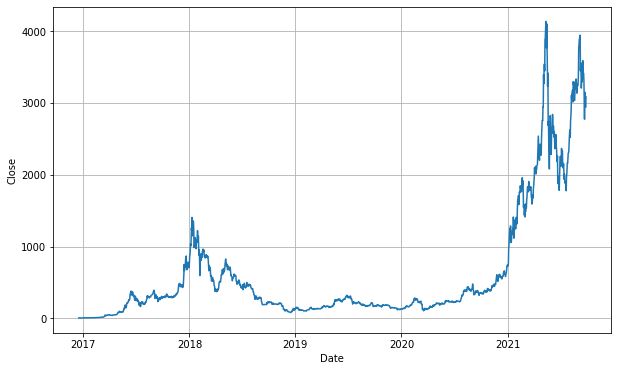

In [5]:
plt.figure(figsize=(10,6))
plt.grid("True")
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(df['Close'])
plt.show()

In [6]:
df.dropna(inplace=True)

<AxesSubplot:ylabel='Density'>

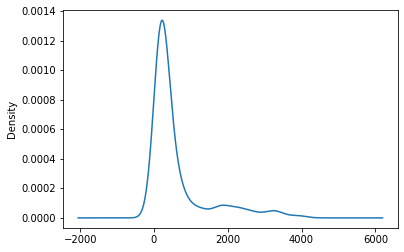

In [7]:
df_close = df['Close']
df_close.plot(kind='kde')

In [8]:
df.isnull().sum()

Currency          0
Close             0
24h Open (USD)    0
24h High (USD)    0
24h Low (USD)     0
dtype: int64

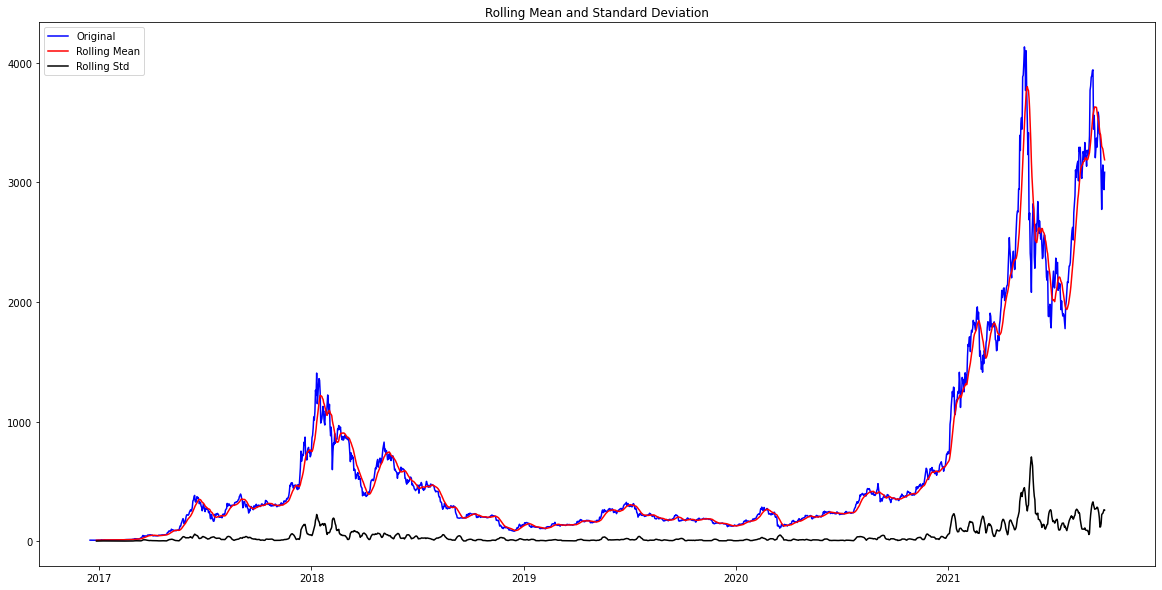

Results of dickey fuller test
Test Statistics                   0.224907
p-value                           0.973624
No. of lags used                 24.000000
Number of observations used    1721.000000
critical value (1%)              -3.434155
critical value (5%)              -2.863221
critical value (10%)             -2.567665
dtype: float64


In [9]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

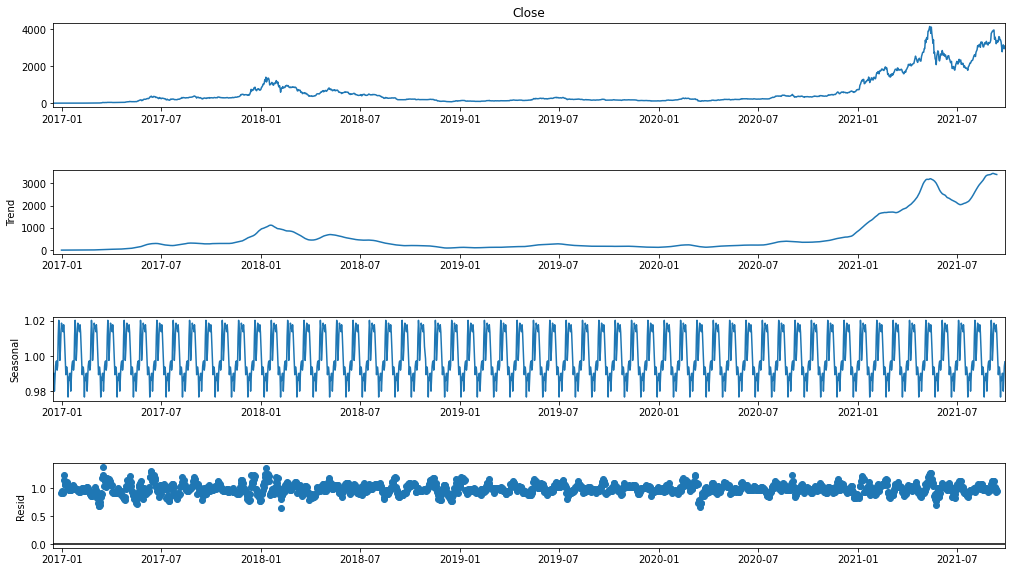

In [10]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

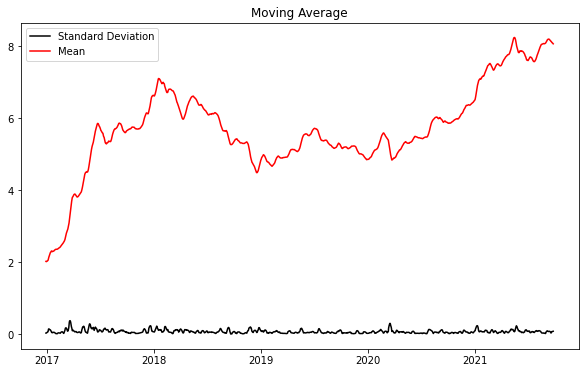

In [11]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

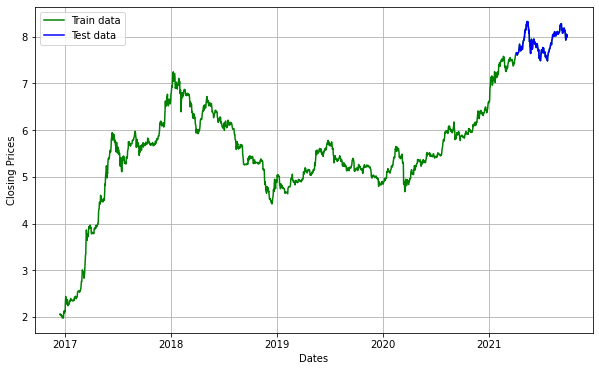

In [12]:
#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4570.637, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4568.637, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4568.635, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4566.418, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4566.637, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.759 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1571
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2287.318
Date:                Fri, 01 Oct 2021   AIC                          -4570.637
Time:                        05:49:10   BIC                          -4559.919
Sample:                             0   HQIC                         -4566.653
                               - 1571                                  

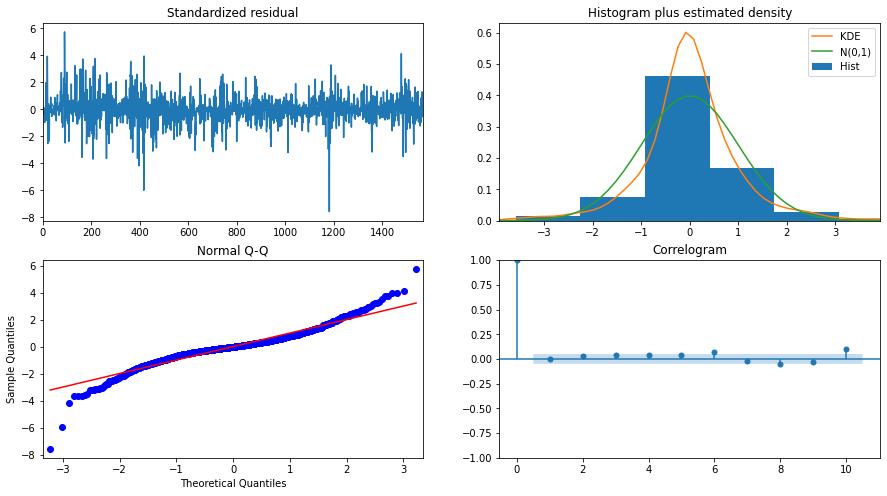

In [13]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [14]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1570
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2287.318
Method:                           css   S.D. of innovations              0.056
Date:                Fri, 01 Oct 2021   AIC                          -4570.637
Time:                        05:49:11   BIC                          -4559.919
Sample:                             1   HQIC                         -4566.653
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.496      0.013       0.001       0.006


In [15]:
# Forecast
fc, se, conf = fitted.forecast(175, alpha=0.05)  # 95% conf

In [16]:
fc_series = pd.Series(fc, index=test_data.index)

In [17]:
import numpy as np

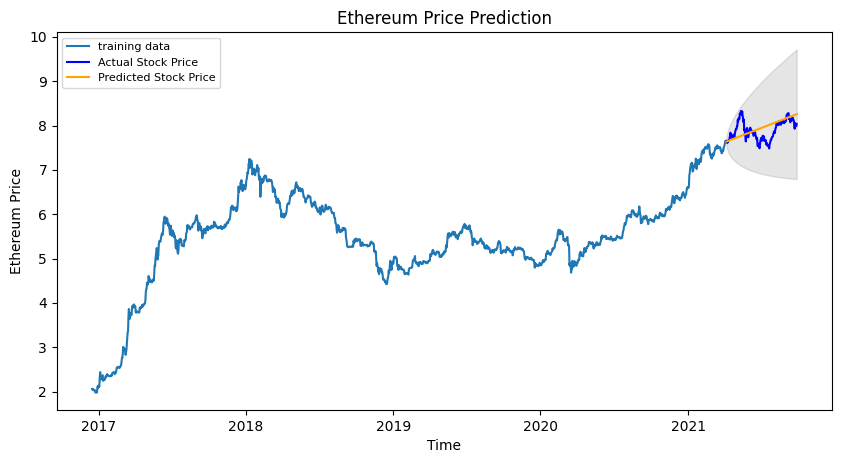

In [18]:
# Make as pandas series

lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Ethereum Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = np.exp(mean_absolute_error(test_data, fc))
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.exp(np.mean(np.abs(fc - test_data)/np.abs(test_data)))
print('MAPE: '+str(mape))

MSE: 0.05611105969707002
MAE: 1.1980642587405477
RMSE: 0.23687773153479416
MAPE: 1.0232768708899782


In [20]:
np.exp(test_data[:10])

Date
2021-04-06    2114.143939
2021-04-07    2117.595811
2021-04-08    2011.550426
2021-04-09    2069.660876
2021-04-10    2070.601411
2021-04-11    2118.705992
2021-04-12    2137.095867
2021-04-13    2144.420464
2021-04-14    2280.907863
2021-04-15    2427.805087
Name: Close, dtype: float64

In [21]:
np.exp(fc[:10])

array([2074.86989283, 2082.25116597, 2089.65869771, 2097.09258148,
       2104.55291102, 2112.0397804 , 2119.55328405, 2127.09351671,
       2134.66057347, 2142.25454975])

<AxesSubplot:xlabel='Date'>

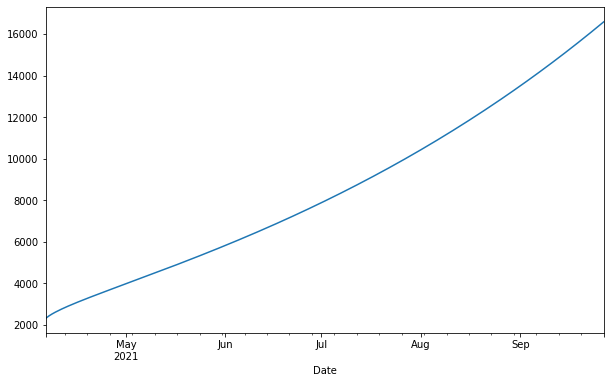

In [22]:
np.exp(upper_series).plot()

<AxesSubplot:xlabel='Date'>

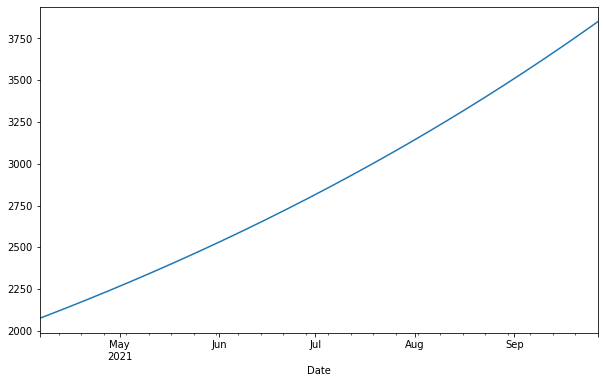

In [23]:
np.exp(fc_series).plot()

<AxesSubplot:xlabel='Date'>

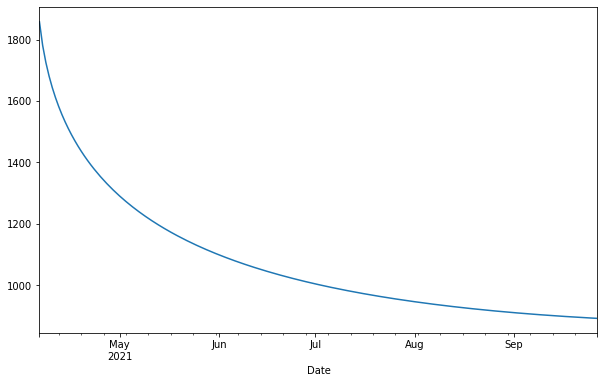

In [24]:
np.exp(lower_series).plot()